In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from math import *
import pickle
import pandas as pd
from tqdm import tqdm
from aero_info import *
from missile_gym import MissileGym
from ipywidgets import interact, interactive, fixed
from matplotlib.pylab import figure, subplot2grid
from interpolation import Interp1d, Interp2d, InterpVec
import ipywidgets

In [2]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [3]:
%matplotlib inline

In [4]:
# настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Баллистическое проектирование ЗУР

**Прототип 48Н6Е** (С-300 ПМУ-1). Бескрылая нормальная схема (частный случай "нормальной" схемы) - "схема с несущим корпусом". Двигатель разгонно-маршевый однорежимный из высокопрочного алюминиевого сплава (таблица 4.3). 

mz_cy = - 0.02...0.06 для обычной схемы (x_t - x_fa) / L_korp

АД ОУ - рули-элероны выполняют еще и роль стабилизирующих поверхностей, обеспечивающих необходимые запасы статической устойчивости.

* стр. 455 про бескрылую схему можно многое узнать

* стр. 511 про нашу ракету написал Грушин

* стр. 527 про бал проектирование

## 1) Первоначальный баллистический расчет
Для начала проинтегрируем систему, приняв угол склонения ракеты **thetta (Q)** постоянным на активном участке полета. Для этого используем упрощенную систему уравнений движения ракеты [*пособие Астахова "Бал. пр-е", система ур-ний (4)*], где все переменные коэф-ты выраженны через проектные параметры ракеты, при **alpha = 0**, следовательно, и **Cya = 0**. Найдем минимум стартовой массы ракеты (перебором относительной массы топливного заряда при заданном коэф-те конструктивно-массового совершенства и массе полезной нагрузки из прототипа). Получим в итоге профиль скорости нашей ЗУР, который будет использован в первоначальном АД проектировании для получения коэф-тов Суа от числа М, и Сх от alpha и числа М. Далее будем использовать исходную полную систему уравнений движения [*Физ. основы устр-ва ракетного оружия, глава 3*] для уточнения баллистического расчёта и дальнешего АД расчета.

### 1.1. Простая прогонка с параметрами прототипа

In [5]:
alpha, Cy_alpha = 0, 0

In [6]:
# Пример формирования словаря с начальными данными одноступенчатой ракеты (аналог - ЗУР 48Н6E ЗРС С-300 ПМУ-1)
opts = {
    'init_conditions': {'l_pusk': 8,
                        'x': 0,
                        'y': 20,
                        'v': 25,
                        'thetta': 35},
    'η_0': 14,
    'I_10': 2700,
    'myu_0': 0.59,
    'lambda_e': 2.373,
    'k': 1.21,
    'p_00': 5*1e6,
    'q_M': 2400 * 9.80665 / (np.pi * 0.515**2 / 4),
    'i': 1.2,
    'integr': {'stop_conditions': 'x_max',
               'value': 2e5,
               'dt': 5e-1}
}  
m_бч = 145
m_пн = 730
α_д = 0.18

In [7]:
def ozvb(dict_opts):
    
    """
    Ф-ция решения прямой задачи внешней баллистики (ОЗВБ) ракеты
    argument:  dict_opts {dict}  -- словарь с опциями (начальными данными)
    return:    dict_res  {dict}  -- словарь с результатами решения ОЗВБ
    """
    
    # const:
    g     = 9.80665
    p_h0  = 101325
    k_air = 1.41
    
    def func_stop(stop_conditions):
        if stop_conditions == 't0':
            return lambda t: dict_opts['I_10'] * dict_opts['myu_0'] / dict_opts['η_0'] / g - t
        if stop_conditions == 'v_max':
            return lambda v: dict_opts['integr']['value'] - v
        if stop_conditions == 'y_max':
            return lambda y: dict_opts['integr']['value'] - y
        if stop_conditions == 'x_max':
            return lambda x: dict_opts['integr']['value'] - x
        if stop_conditions == 'step_max':
            return lambda i: dict_opts['integr']['value'] - i
        if stop_conditions == 't_max':
            return lambda t: dict_opts['integr']['value'] - t

    def f(λ, k):
        # табличная газодинамическая функция
        return (1 + λ ** 2) * (1 - ((k - 1) / (k + 1)) * λ ** 2) ** (1 / (k - 1))

    def π(y):
        # ф-ция изменения атмосф. давления с высотой
        p_h = table_atm(y, 2)
        return p_h / p_h0

    def ξ_stage(μ, μ_0):
        # ф-ция, учитывающая отстыковку стартовой ступени (для двухступенчатых ракет)
        if μ < μ_0:
            return 1
        else:
            return 0
   
    def ξ_pusk(x, y):
        # ф-ция, учитывающая неизменность угла наклона траектории при движении ракеты по направляющей
        if np.sqrt(x ** 2 + y ** 2) <= dict_opts['init_conditions']['l_pusk']:
            return 0
        else:
            return 1

    def system(t, Y, r=dict_opts, Cx=Cx43):
            
        y1 = Y[0] # v
        y2 = Y[1] # θ
        y3 = Y[2] # x
        y4 = Y[3] # y
        y5 = Y[4] # μ 
        
        M  = y1 / table_atm(y4, 4)
        
        a10_1 = g * r['η_0'] / (1 - y5)
        a10_2 = g * r['η_0'] * (1 - π(y4)) / ((f(r['lambda_e'], r['k']) * (r['p_00'] / p_h0) - 1) * (1 - y5))
        a1_3  = g * r['i'] * Cx(M) * k_air * p_h0 * π(y4) * (M ** 2) / (2 * r['q_M'] * (1 - y5))
        a1_4  = g * np.sin(y2)
        
        # dv/dt
        f1 = (a10_1 + a10_2) * ξ_stage(y5, r['myu_0']) - a1_3 - a1_4
        # dθ/dt
        f2 = g * ξ_pusk(y3, y4) / (y1 ** (ξ_pusk(y3, y4))) * (Cy_alpha * alpha * table_atm(y4, 3) * y1 ** 2 / (2 * r['q_M'] * (1 - y5)) + r['η_0'] * np.sin(np.radians(alpha)) / (1 - y5) - np.cos(y2) * (1 - ξ_stage(y5, r['myu_0'])))
        # dx/dt
        f3 = y1 * np.cos(y2)
        # dy/dt
        f4 = y1 * np.sin(y2)
        # dμ/dt
        f5 = g * (r['η_0'] / r['I_10']) * ξ_stage(y5, r['myu_0'])
        
        return np.array([f1, f2, f3, f4, f5])
   
    def RK4(F, Y0, stop_conditions=dict_opts['integr']['stop_conditions'],
            func_end=func_stop(dict_opts['integr']['stop_conditions']), 
            dt=dict_opts['integr']['dt'], y=dict_opts['init_conditions']['y'],
            t0=0, max_time=300): 
        
        ti = t0 
        Yi = Y0
        res = {
        'y1': [Y0[0]],
        'y2': [Y0[1]],
        'y3': [Y0[2]],
        'y4': [Y0[3]],
        'y5': [Y0[4]],
        'Mach': [Y0[0]/table_atm(Y0[3],4)],
        't': [t0],
        'stop_reason': ''        
        }

        def foo_init_stop(stop_conditions, fint, *args):
            if stop_conditions == 't0':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            elif stop_conditions == 'v_max':
                if fint == 1:
                    return args[0][0]
                if fint == 0:
                    return Y0[0]
            elif stop_conditions == 'y_max':
                if fint == 1:
                    return args[0][3]
                if fint==0:
                    return Y0[3]
            elif stop_conditions == 'x_max':
                if fint == 1:
                    return args[0][2]
                if fint == 0:
                    return Y0[2]
            elif stop_conditions == 't_max':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            else:
                print('unknown condition')
        
        flag = True
        var = foo_init_stop(stop_conditions, 0, Yi, ti)
        
        while func_end(var) > 0 and ti < max_time and Yi[3] < 8e4 and flag == True:
            
            k1 = F(ti, Yi)
            k2 = F(ti + dt / 2, Yi + k1 * dt / 2)
            k3 = F(ti + dt / 2, Yi + k2 * dt / 2)
            k4 = F(ti + dt, Yi + k3 * dt)
            Yi += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
            ti += dt
            if Yi[3] <= 0:
                flag = False
            
            var = foo_init_stop(stop_conditions, 1, Yi, ti)
            
            res['y1'].append(Yi[0])
            res['y2'].append(Yi[1])
            res['y3'].append(Yi[2])
            res['y4'].append(Yi[3])
            res['y5'].append(Yi[4])
            res['Mach'].append(Yi[0]/table_atm(Yi[3],4))
            res['t'].append(ti)
            
        if func_end(var) < 0:
            stop_reason = dict_opts['integr']['stop_conditions']
        elif ti >= max_time:
            stop_reason = 'max_time'
        elif Yi[3] <= 0:
            stop_reason = f'missile arrived (x = {Yi[2]}; y = 0)'
        elif Yi[3] >= 8e4:
            stop_reason = 'y_max_atmo'
        else:
            stop_reason = 'unknown reason'
        res['stop_reason'] = stop_reason
        print(f'stop reason: {stop_reason};\nflight time: {ti} с.;')
        
        return res
    
    init = [dict_opts['init_conditions']['v'], np.radians(dict_opts['init_conditions']['thetta']),
            dict_opts['init_conditions']['x'], dict_opts['init_conditions']['y'], 0]
    
    fl_start = timeit.default_timer()
    res = RK4(system, init)
    fl_end   = timeit.default_timer() - fl_start 
    print(f'execution time: {fl_end} с.')
    
    dict_res = {
        'v': np.array(res['y1']),
        'thetta': np.array(res['y2']),
        'x':  np.array(res['y3']),
        'y': np.array(res['y4']),
        'myu':  np.array(res['y5']),
        't':  np.array(res['t']),
        'Mach': np.array(res['Mach']),
        'stop_reason': res['stop_reason'],
        'execution_time': fl_end
    }

    return dict_res

In [8]:
res = ozvb(opts)

stop reason: x_max;
flight time: 150.5 с.;
execution time: 18.158771599999994 с.


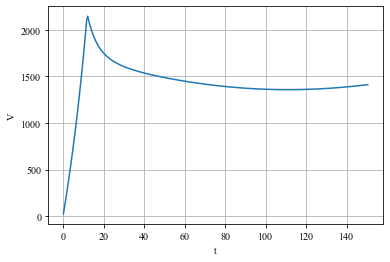

In [9]:
plt.figure()
plt.plot(res['t'], res['v'])
plt.grid()
plt.xlabel('t'), plt.ylabel('V') 
plt.show()

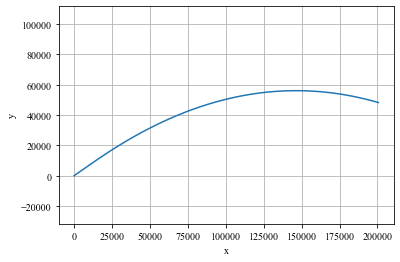

In [10]:
plt.figure()
plt.plot(res['x'], res['y'])
plt.xlabel('x'), plt.ylabel('y') 
plt.axis('equal')
plt.ylim(0, 8e4)
plt.grid()
plt.show()

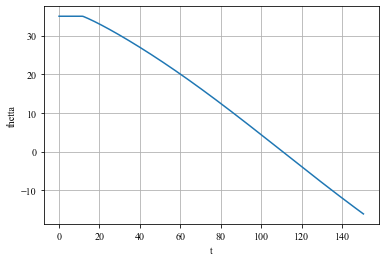

In [11]:
plt.figure()
plt.plot(res['t'], np.degrees(res['thetta']))
plt.xlabel('t'), plt.ylabel('thetta') 
plt.grid()
plt.show()

### 1.2. Поиск оптимального начального угла склонения ракеты Q0

In [ ]:
mass_thetta = np.arange(20, 65, 5)
mass_y_end  = []
mass_x_end  = []
mass_stop   = []
for i in mass_thetta:
    opts['init_conditions']['thetta'] = i
    res = ozvb(opts)
    mass_y_end.append(res['y'][-1])
    mass_x_end.append(res['x'][-1])
    mass_stop.append(res['stop_reason'])  
mass_y_end = np.array(mass_y_end)
mass_x_end = np.array(mass_x_end)

In [ ]:
y_end_max = mass_y_end[0]
for i in range(len(mass_x_end)):
    if mass_stop[i] == 'x_max' and mass_y_end[i] > y_end_max and mass_y_end[i] < 35e3:
        thetta_opt = mass_thetta[i]

In [ ]:
from interpolation import Interp1d, Interp2d, InterpVec
thetta_itr = Interp1d(mass_y_end, mass_thetta)
thetta_itr(3e4)

In [ ]:
plt.figure(dpi=100)
plt.plot(mass_thetta, mass_x_end/1e3, label='$D_{max}$')
plt.plot(mass_thetta, mass_y_end/1e3, label='$H_{end}$')
plt.vlines(thetta_opt, 0, 200, ls='-.', color='grey')
plt.hlines(30, 0, thetta_opt, ls='-.', color='grey')
plt.xlabel('θ$_0$, град')
plt.ylabel('$D_{max}$, $H_{end}$ [км]')
plt.text(thetta_opt, -15, 'θ$_{opt}$')
plt.text(20, 35, 'H$_{end}$=30')
plt.legend()
plt.grid()
plt.ylim(0,205)
plt.xlim(20,60)
plt.savefig('pictures/Поиск оптимального угла.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
thetta_opt = 31.857218264235136

In [9]:
opts['init_conditions']['thetta'] = thetta_opt

### 1.3. Поиск минимума стартовой массы ракеты

In [ ]:
mass_μ_0 = np.arange(0.55, 0.66, 0.01)

In [ ]:
mass_m_0, mass_V_0, mass_myu_0 = [], [], []
for i in mass_μ_0:
    opts['myu_0'] = i
    m_0 = m_пн / (1 - (1 + α_д) * i)
    opts['q_M'] = m_0 * 9.80665 / (np.pi * 0.515**2 / 4)
    res = ozvb(opts)
    if res['stop_reason'] == 'x_max' and max(res['v']) > 2100:
        mass_m_0.append(m_0)
        mass_V_0.append(max(res['v']))
        mass_myu_0.append(i)

In [ ]:
ind_min, m_0_opt = np.argmin(mass_m_0), min(mass_m_0)
myu_0_opt = mass_myu_0[ind_min]
t_0 = opts['I_10'] * myu_0_opt / opts['η_0'] / 9.80665
print(f'Стартовая масса ракеты m0 = {m_0_opt} (μ = {myu_0_opt})')
print(f'Время работы ДУ t = {t_0}')

### 1.4. Получаем профиль скорости и траекторию полёта

In [ ]:
opts['myu_0'] = myu_0_opt
opts['q_M'] = m_0_opt * 9.80665 / (np.pi * 0.515**2 / 4)
opts['integr']['dt'] = 0.5

In [10]:
res = ozvb(opts)

stop reason: x_max;
flight time: 152.5 с.;
execution time: 14.756109500000008 с.


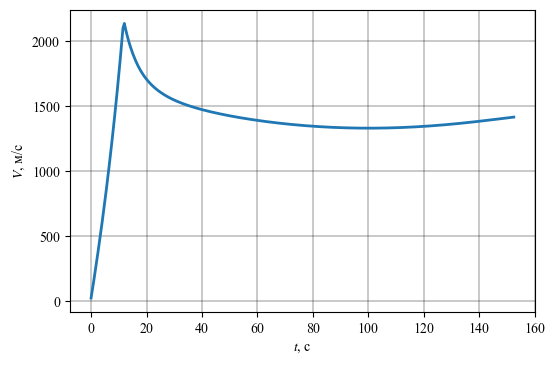

(2134.073637948761, 1388.5738644117987)

In [11]:
plt.figure(dpi=100)
plt.plot(res['t'], res['v'], linewidth=2)
plt.grid()
plt.xlabel('$t$, с'), plt.ylabel('$V$, м/с') 
plt.grid(True, linewidth=0.3, color='k')
plt.savefig('pictures/профиль скорости начальный.png', dpi=300, bbox_inches='tight')
plt.show()
max(res['v']), np.mean(res['v'])

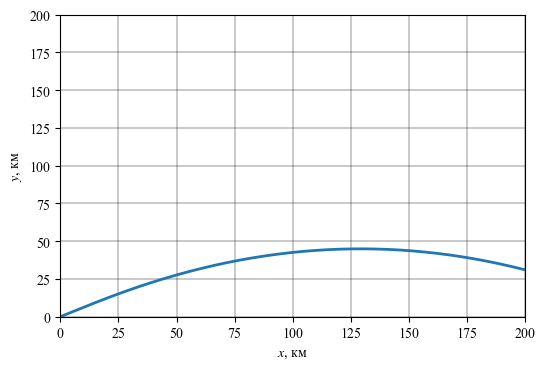

In [12]:
plt.figure(dpi=100)
plt.plot(res['x']/1e3, res['y']/1e3, linewidth=2)
plt.xlabel('$x$, км'), plt.ylabel('$y$, км') 
plt.xlim(0, 200), plt.ylim(0, 200)
plt.grid(True, linewidth=0.3, color='k')
plt.show()

In [13]:
g = 9.80665
m_0 = opts['q_M'] * np.pi * 0.515**2 / (9.80665 * 4)
d = 0.515 # из прототипа
gamma = 1500 # плотность ракеты по статистике (удельный вес)
q_m = (4 * m_0 * g) / (np.pi * d**2)
l_korp = m_0 / (np.pi * d**2 / 4 * gamma)
lambd_korp = l_korp / d
w_marsh = m_0 * opts['myu_0']
t_marsh = opts['I_10'] * opts['myu_0'] / opts['η_0'] / g
G_marsh = w_marsh / t_marsh
P_marsh = opts['η_0'] * g * m_0 #  у прототипа 220000
print(f'Стартовая масса ракеты: m0 = {m_0} кг;')
print(f'Нагрузка на мидель на старте: q = {q_m} Н/м^2;')
print(f'Длина корпуса ракеты: l = {l_korp} м (длина ТПК 7810 мм);')
print(f'Удлинение корпуса ракеты: λ = {lambd_korp};')
print(f'Масса топлива двигателя: w = {w_marsh} кг;')
print(f'Время работы двигателя: t = {t_marsh} с;')
print(f'Расход топлива: G = {G_marsh} кг/с;')
print(f'Тяга ДУ: P = {P_marsh} Н;')

Стартовая масса ракеты: m0 = 2399.9999999999995 кг;
Нагрузка на мидель на старте: q = 112986.7659357338 Н/м^2;
Длина корпуса ракеты: l = 7.680962471774003 м (длина ТПК 7810 мм);
Удлинение корпуса ракеты: λ = 14.914490236454375;
Масса топлива двигателя: w = 1415.9999999999995 кг;
Время работы двигателя: t = 11.602913766241713 с;
Расход топлива: G = 122.03831111111107 кг/с;
Тяга ДУ: P = 329503.4399999999 Н;


## 2) Определение АД коэффициентов для более подробной мат модели

### 2.1. Центровочный расчет ракеты

In [127]:
# длины отсеков
L1, L2, L3, L4, L5 = 1.360, 1.163, 0.465, 3.863, 0.849

In [128]:
L1+L2+L3+L4+L5

7.7

In [129]:
w_marsh = 1547.279
α_д = 0.236

In [130]:
α_д * w_marsh

365.15784399999995

In [131]:
# плотности отсеков
rho1, rho2, rho3, rho5 = 350, 630, 1500, 800

In [132]:
L_korp = 7700 / 1e3
L_cil = 4567 / 1e3
L_korm = 135 / 1e3
# L_oper = 1200 / 1e3
b_0_oper = 1360.030793 / 1e3
L_kon1 = 1360 / 1e3
L_kon2 = 1628 / 1e3
x_b_oper = 6500 / 1e3
a = 0.2 # 0.15...0,2
betta_kon2 = 1
d = 515 / 1e3
d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
d_kon2 = d_kon1 + 2 * np.tan(np.radians(betta_kon2)) * L2
d_korm = 464 / 1e3
c_oper = 0.03
khi_pk_oper = 50
khi_rul = 0
class_korp = 7
class_oper = 5
# S_oper =  1.20092864206
x_ct_0 = 4.719208153897406
x_ct_marsh = 4.333379398949821

In [133]:
# объемы отсеков
V1 = 1/3 * np.pi * (d_kon1/2)**2 * L_kon1
V2 = 1/3 * np.pi * L2 * ((d_kon1/2)**2 + (d_kon1/2) * (d_kon2/2) + (d_kon2/2)**2)
V3 = 1/3 * np.pi * L3 * ((d_kon2/2)**2 + (d_kon2/2) * (d/2) + (d/2)**2)
V4 = 1/4 * np.pi * d**2 * L4 
V5 = 1/4 * np.pi * d**2 * (L5 - L_korm) + 1/3 * np.pi * L_korm * ((d/2)**2 + (d/2)*(d_korm/2) + (d_korm/2)**2)
V1, V2, V3, V4, V5

(0.07474012762427584,
 0.2092344884749249,
 0.09384174611213834,
 0.8046908213278218,
 0.17415991823135216)

In [134]:
# массы отсеков
Q1, Q2, Q3, Q4, Q5 = rho1 * V1, rho2 * V2, rho3 * V3, w_marsh + α_д * w_marsh, rho5 * V5
Q1, Q2, Q3, Q4, Q5

(26.159044668496545,
 131.8177277392027,
 140.76261916820752,
 1912.4368439999998,
 139.32793458508172)

In [135]:
# масса ракеты
Q1 + Q2 + Q3 + Q4 + Q5

2350.504170160988

In [136]:
# центры масс отсеков
x_ct1 = 2/3 * L_kon1
r_kon1, r_kon2 = d_kon1/2, d_kon2/2
x_ct2 = L_kon1 + (L2 - L2/4 * ((r_kon2**2 + 2*r_kon1*r_kon2 + 3*r_kon1**2) / (r_kon2**2 + r_kon1*r_kon2 + r_kon1**2)))
x_ct3 = L_kon1 + L2 + (L3 - L3/4 * ((r_kon2**2 + 2*r_kon1*r_kon2 + 3*r_kon1**2) / (r_kon2**2 + r_kon1*r_kon2 + r_kon1**2)))
x_ct4 = L_kon1 + L_kon2 + L4/2
x_ct5 = L_kon1 + L_kon2 + L4 + L5/2
x_ct1, x_ct2, x_ct3, x_ct4, x_ct5

(0.9066666666666667, 1.957937945958474, 2.762072351565512, 4.9195, 7.2755)

In [137]:
# центры масс ракеты в характерных точках
x_ct_0 = (Q1 * x_ct1 + Q2 * x_ct2 + Q3 * x_ct3 + Q4 * x_ct4 + Q5 * x_ct5) / (Q1 + Q2 + Q3 + Q4 + Q5)
x_ct_marsh = (Q1 * x_ct1 + Q2 * x_ct2 + Q3 * x_ct3 + (α_д * w_marsh) * x_ct4 + Q5 * x_ct5) / (Q1 + Q2 + Q3 + (α_д * w_marsh) + Q5)
x_ct_0, x_ct_marsh

(4.719208153897406, 4.333379398949821)

In [138]:
x_ct1 - x_ct_0, x_ct2 - x_ct_0, x_ct3 - x_ct_0, x_ct4 - x_ct_0, x_ct5 - x_ct_0

(-3.8125414872307393,
 -2.761270207938932,
 -1.9571358023318939,
 0.2002918461025942,
 2.556291846102594)

In [139]:
x_ct1 - x_ct_marsh, x_ct2 - x_ct_marsh, x_ct3 - x_ct_marsh, x_ct4 - x_ct_marsh, x_ct5 - x_ct_marsh

(-3.426712732283154,
 -2.3754414529913466,
 -1.5713070473843085,
 0.5861206010501796,
 2.9421206010501795)

In [140]:
I1 = Q1 * (x_ct1 - x_ct_0) ** 2
I2 = Q2 * (x_ct2 - x_ct_0) ** 2
I3 = Q3 * (x_ct3 - x_ct_0) ** 2
I4 = Q4 * (x_ct4 - x_ct_0) ** 2
I5 = Q5 * (x_ct5 - x_ct_0) ** 2
I0 = I1 + I2 + I3 + I4 + I5
I0

2911.6447714795327

In [141]:
I1пуст = Q1 * (x_ct1 - x_ct_marsh) ** 2
I2пуст = Q2 * (x_ct2 - x_ct_marsh) ** 2
I3пуст = Q3 * (x_ct3 - x_ct_marsh) ** 2
I4пуст = (Q4-w_marsh) * (x_ct4 - x_ct_marsh) ** 2
I5пуст = (Q5) * (x_ct5 - x_ct_marsh) ** 2
Iпуст = I1пуст + I2пуст + I3пуст + I4пуст + I5пуст
Iпуст

2730.001679060948

In [142]:
# разбежка центра масс
razbezhka = (x_ct_0 - x_ct_marsh) / L_korp * 100
razbezhka

5.010763051267342

### 2.2. Определение АД характеристик на траектории полета полученного профиля скорости

In [143]:
def get_P(t):
    if t < t_marsh:
        return P_marsh
    else:
        return 0

In [144]:
def get_x_ct(t):
    dx_ct = abs(x_ct_0 - x_ct_marsh) / t_marsh
    if t < t_marsh:
        return x_ct_0 - dx_ct * t
    else:
        return x_ct_marsh

In [145]:
def aero_coef(state, params):
    """
    Ф-ция расчёта аэродинамических коэффициентов ракеты в состоянии state
    arguments: state {np.ndarray}             -- состояние ракеты:
                                                 [v,   x, y, Q,       alpha,   t]
                                                 [м/с, м, м, радианы, градусы, с]
               params {np.ndarray/list/tuple} -- варьируемые параметры:
                                                 [S_oper, x_b_oper, L_oper, khi_pk_oper]
    return: {dict}                            -- словарь с АД коэф-тами 
    """ 
    
    S_oper, x_b_oper, L_oper, khi_pk_oper = params
    
    v, x, y, alpha, t = state[0], state[1], state[2], state[4], state[5] 
    Mach = v / table_atm(y, 4)
    nyu = table_atm(y, 6)
    x_ct = get_x_ct(t)
    Re_korp_f = v * L_korp / nyu
    Re_korp_t = table_4_5(Mach, Re_korp_f, class_korp, L_korp)
    
    
    # Вычисление геометрии корпуса:
    L_nos = L_kon1 + L_kon2
    d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
    betta_kon1 = (d_kon1 / 2) / L_kon1
    S_kon1 = np.pi * d_kon1**2 / 4
    S_mid = np.pi * d**2 / 4
    S_dno = np.pi * d_korm**2 / 4
    F_f = (np.pi * d_kon1/2 * np.sqrt((d_kon1/2)**2 + L_kon1**2)) + (np.pi * (d_kon1/2 + d/2) * np.sqrt((d/2 - d_kon1/2)**2 + L_kon2**2)) + (np.pi * d * L_cil) + (np.pi * (d_korm/2 + d/2) * np.sqrt((d/2 - d_korm/2)**2 + L_korm**2))
    W_nos = 1/3 * L_kon1 * S_mid + 1/3 * np.pi * L_kon2 * ((d_kon1/2)**2 + (d_kon1/2)*(d/2) + (d/2)**2)
    lambd_korp = L_korp / d
    lambd_nos = L_nos / d
    lambd_cil = L_cil / d
    lambd_korm = L_korm / d
    nu_korm = d_korm / d
    
    
    # Вычисление геометрии рулей (оперения):
    D_oper = d / L_oper
    L_k_oper = L_oper - d
    tg_khi_pk_oper = np.tan(np.radians(khi_pk_oper))
    lambd_oper = L_oper**2 / S_oper
    nu_oper = (S_oper / (L_oper * b_0_oper) - 0.5) ** (-1) / 2
    b_k_oper = b_0_oper / nu_oper
    b_a_oper = 4 / 3 * S_oper / L_oper * (1 - (nu_oper / (nu_oper + 1) ** 2))
    b_b_oper = b_0_oper * (1 - (nu_oper - 1) / nu_oper * d / L_oper)
    z_a_oper = L_oper / 6 * ((nu_oper + 2) / (nu_oper + 1))
    S_k_oper = S_oper * (1 - ((nu_oper - 1) / (nu_oper + 1)) * d / L_oper) * (1 - d / L_oper)
    nu_k_oper = nu_oper - d / L_oper * (nu_oper - 1)
    lambd_k_oper = lambd_oper * ((1 - d / L_oper) / (1 - ((nu_oper - 1) / (nu_oper + 1) * d / L_oper)))
    tg_khi_05_oper = tg_khi_pk_oper - 2 / lambd_oper * (nu_k_oper - 1) / (nu_k_oper + 1)
    a_oper = 2/3 * b_b_oper
    K_oper = 1 / (1 - a_oper / b_a_oper)
    L_hv_oper = L_korp - x_b_oper - b_b_oper
    if tg_khi_pk_oper == 0:
        x_b_a_oper = x_b_oper
    else:
        x_b_a_oper = x_b_oper + (z_a_oper - d / 2) * tg_khi_pk_oper

    
    # Коэф-т подъемной силы корпуса
    if Mach <= 1:
        Cy_alpha_nos = 2 / 57.3 * (1 + 0.27 * Mach**2)
    else:
        Cy_alpha_nos = 2 / 57.3 * (np.cos(np.radians(betta_kon1))**2 * S_kon1 / S_mid
                                   + np.cos(np.radians(betta_kon2))**2 * (1 - S_kon1 / S_mid))
    Cy_alpha_korm = - 2 / 57.3 * (1 - nu_korm ** 2) * a
    Cy_alpha_korp = Cy_alpha_nos + Cy_alpha_korm
    
    
    # Коэф-т подъемной силы оперения по углу атаки
    K_t_oper = table_3_21(Mach, lambd_nos)
    Cy_alpha_k_oper = Cy_alpha_iz_kr(Mach * np.sqrt(K_t_oper), lambd_oper, c_oper, tg_khi_05_oper)
    k_aa_oper = (1 + 0.41 * D_oper)**2 * ((1 + 3 * D_oper - 1 / nu_k_oper * D_oper * (1 - D_oper)) / (1 + D_oper)**2)
    K_aa_oper = 1 + 3 * D_oper - (D_oper * (1 - D_oper)) / nu_k_oper
    Cy_alpha_oper = Cy_alpha_k_oper * K_aa_oper
    
    
    # Коэф-т подъемной силы оперения (рулей) по углу их отклонения
    K_delt_0_oper = k_aa_oper
    k_delt_0_oper = k_aa_oper ** 2 / K_aa_oper
    if Mach <= 1:
        k_shch = 0.825
    elif 1 < Mach <= 1.4:
        k_shch = 0.85 + 0.15 * (Mach - 1) / 0.4
    else:
        k_shch = 0.975
    n_eff = k_shch * np.cos(np.radians(khi_rul))
    Сy_delt_oper = Cy_alpha_k_oper * K_delt_0_oper * n_eff
    
    
    # Коэф-т подъемной силы ракеты
    Cy_alpha = Cy_alpha_korp * (S_mid / S_mid)  + Cy_alpha_oper * (S_oper / S_mid) * K_t_oper    
      
    
    # Сопротивление корпуса
    x_t = Re_korp_t * nyu / v
    x_t_ = x_t / L_korp
    Cx_f_ = table_4_2(Re_korp_f, x_t_) / 2
    nu_m = table_4_3(Mach, x_t_)
    nu_c = 1 + 1 / lambd_nos
    Cx_tr = Cx_f_ * (F_f / S_mid) * nu_m * nu_c
    
    if Mach > 1:
        p_kon1_ = (0.0016 + 0.002 / Mach**2) * betta_kon1**1.7
        p_kon2_ = (0.0016 + 0.002 / Mach**2) * betta_kon2**1.7
        Cx_nos = p_kon1_ * (S_kon1 / S_mid) + p_kon2_ * (1 - (S_kon1 / S_mid))
    else:
        Cx_nos = table_4_11(Mach, lambd_nos)

    Cx_korm = table_4_24(Mach, nu_korm, lambd_korm)
    
    if get_P(t) == 0:
        p_dno_ = table_p_dno_(Mach, oper=True)
        K_nu = table_k_nu(nu_korm, lambd_korm, Mach)
        Cx_dno = p_dno_ * K_nu * (S_dno / S_mid)
    else:
        Cx_dno = 0
    Cx_0_korp = Cx_tr + Cx_nos + Cx_korm + Cx_dno
    
    if Mach < 1:
        phi = -0.2
    else:
        phi = 0.7
    Cx_ind_korp = Cy_alpha_korp * alpha**2 * ((1 + phi) / 57.3)
    
    Cx_korp = Cx_0_korp + Cx_ind_korp
    
    
    # Сопротивление оперения
    Re_oper_f = v * b_a_oper / nyu
    Re_oper_t = table_4_5(Mach, Re_oper_f, class_oper, b_a_oper)
    x_t_oper = Re_oper_t / Re_oper_f
    C_f_oper = table_4_2(Re_oper_f, x_t_oper)
    nu_c_oper = table_4_28(x_t_oper, c_oper)
    Cx_oper_prof = C_f_oper * nu_c_oper
    
    if Mach < 1.1:
        Cx_oper_voln = table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)
    else:
        phi = table_4_32(Mach, tg_khi_05_oper)
        Cx_oper_voln = (table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)) * (1 + phi * (K_oper - 1))
        
    Cx_0_oper = Cx_oper_prof + Cx_oper_voln
    
    if Mach * np.cos(np.radians(khi_pk_oper)) > 1:
        Cx_ind_oper = (Cy_alpha_oper * alpha) * np.tan(np.radians(alpha))
    else:
        Cx_ind_oper = 0.38 * (Cy_alpha_oper * alpha)**2 / (lambd_oper - 0.8 * (Cy_alpha_oper * alpha) * (lambd_oper - 1)) *\
        ((lambd_oper / np.cos(np.radians(khi_pk_oper)) + 4) / (lambd_oper + 4))
        
    Cx_oper = Cx_0_oper + Cx_ind_oper
    
    Cx_0 = 1.05 * (Cx_0_korp * (S_mid / S_mid) + Cx_0_oper * K_t_oper * (S_oper / S_mid))
    Cx_ind = Cx_ind_korp * (S_mid / S_mid) + Cx_ind_oper * (S_oper / S_mid) * K_t_oper
    Cx = Cx_0 + Cx_ind
    
    
    # Центр давления корпуса
    delta_x_f = F_iz_korp(Mach, lambd_nos, lambd_cil, L_nos)
    x_fa_nos_cil = L_nos - W_nos / S_mid + delta_x_f
    x_fa_korm = L_korp - 0.5 * L_korm   
    x_fa_korp = 1 / Cy_alpha_korp * (Cy_alpha_nos * x_fa_nos_cil + Cy_alpha_korm * x_fa_korm)
    
    
    # Фокус оперения по углу атаки
    x_f_iz_oper_ = F_iz_kr(Mach, lambd_k_oper, tg_khi_05_oper, nu_k_oper)
    x_f_iz_oper = x_b_a_oper + b_a_oper * x_f_iz_oper_
    f1 = table_5_11(D_oper, L_k_oper)
    x_f_delt_oper = x_f_iz_oper - tg_khi_05_oper * f1
    if Mach > 1:
        b__b_oper = b_b_oper / (np.pi / 2 * d * np.sqrt(Mach ** 2 - 1))
        L__hv_oper = L_hv_oper / (np.pi * d * np.sqrt(Mach ** 2 - 1))
        c_const_oper = (4 + 1 / nu_k_oper) * (1 + 8 * D_oper ** 2)
        F_1_oper = 1 - 1 / (c_const_oper * b__b_oper ** 2) * (1 - np.exp(-c_const_oper * b__b_oper ** 2))
        F_oper = 1 - np.sqrt(np.pi) / (2 * b__b_oper * np.sqrt(c_const_oper)) * (table_int_ver((b__b_oper + L__hv_oper) *\
                np.sqrt(2 * c_const_oper)) - table_int_ver(L__hv_oper * np.sqrt(2 * c_const_oper)))
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_ * F_oper * F_1_oper
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)
    else:
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)

        
    # Фокус оперения по углу отклонения
    x_fd_oper = 1 / K_delt_0_oper * (k_delt_0_oper * x_f_iz_oper + (K_delt_0_oper - k_delt_0_oper) * x_f_ind_oper)
    
    
    # Фокус ракеты
    x_fa = 1 / Cy_alpha * ((Cy_alpha_korp * (S_mid / S_mid) * x_fa_korp) + Cy_alpha_oper * (S_oper / S_mid) * x_fa_oper * K_t_oper)
    
    
    # Демпфирующие моменты АД поверхностей
    x_c_ob = L_korp * ((2 * (lambd_nos + lambd_cil)**2 - lambd_nos**2) / (4 * (lambd_nos + lambd_cil) * (lambd_nos + lambd_cil - 2 / 3 * lambd_nos)))
    m_z_wz_korp = - 2 * (1 - x_ct / L_korp + (x_ct / L_korp) ** 2 - x_c_ob / L_korp)

    x_ct_oper_ = (x_ct - x_b_a_oper) / b_a_oper
    mz_wz_cya_iz_kr = table_5_15(nu_oper, lambd_oper, tg_khi_05_oper, Mach)
    B1 = table_5_16(lambd_oper, tg_khi_05_oper, Mach)
    m_z_wz_oper = (mz_wz_cya_iz_kr - B1 * (1 / 2 - x_ct_oper_) - 57.3 * (1 / 2 - x_ct_oper_)**2) * K_aa_oper * Cy_alpha_k_oper

    m_z_wz = m_z_wz_korp * (S_mid / S_mid) * (L_korp / L_korp)**2 + m_z_wz_oper * (S_oper / S_mid) * (b_a_oper / L_korp)**2 * np.sqrt(K_t_oper)

    
    # Балансировочная зависимость
    M_z_delt = Сy_delt_oper * (x_ct - x_fd_oper) / L_korp
    M_z_alpha = Cy_alpha * (x_ct - x_fa) / L_korp
    ballans_relation = - (M_z_alpha / M_z_delt)

    
    # Запас статической устойчивости
    m_z_cy = (x_ct - x_fa) / L_korp
    
    
    return {
        'Cy_alpha': Cy_alpha,
        'Cy_alpha_korp': Cy_alpha_korp,
        'Cy_alpha_oper': Cy_alpha_oper,
        'Cx': Cx,
        'Cx_0': Cx_0,
        'Cx_0_korp': Cx_0_korp,
        'Cx_0_oper': Cx_0_oper,
        'Cx_ind': Cx_ind,
        'Cx_ind_korp': Cx_ind_korp,
        'Cx_ind_oper': Cx_ind_oper,
        'x_fa': x_fa,
        'x_fa_korp': x_fa_korp,
        'x_fa_oper': x_fa_oper,
        'x_fd_oper': x_fd_oper,
        'm_z_cy': m_z_cy,
        'm_z_wz': m_z_wz,
        'm_z_wz_korp': m_z_wz_korp,
        'm_z_wz_oper': m_z_wz_oper,
        'ballans_relation': ballans_relation,
        'M_z_alpha': M_z_alpha,
        'M_z_delt': M_z_delt
    }

In [146]:
def foo_aero(solve, alpha, params):
    
    Cya = []
    Cy_alpha_korp = []
    Cy_alpha_oper = []
    Cx = []
    Cx_0 = []
    Cx_ind = []
    Cx_0_korp = []
    Cx_ind_korp = []
    Cx_0_oper = []
    Cx_ind_oper = []
    m_z_cy = []
    m_z_wz = []
    m_z_wz_korp = []
    m_z_wz_oper = []
    x_fa = []
    x_fa_korp = []
    x_fa_oper = []
    x_fd_oper = []
    ballans_relation = []
    M_z_alpha = []
    M_z_delt = []
    t = []
    
    for r in range(len(solve['t'])):
        arg = [solve['v'][r], solve['x'][r], solve['y'][r], solve['thetta'][r], alpha, solve['t'][r]]
        res_aero = aero_coef(arg, params)
        
        Cya.append(res_aero['Cy_alpha'])
        Cy_alpha_korp.append(res_aero['Cy_alpha_korp'])
        Cy_alpha_oper.append(res_aero['Cy_alpha_oper'])
        
        Cx.append(res_aero['Cx'])
        Cx_0.append(res_aero['Cx_0'])
        Cx_ind.append(res_aero['Cx_ind'])
        Cx_0_korp.append(res_aero['Cx_0_korp'])
        Cx_ind_korp.append(res_aero['Cx_ind_korp'])
        Cx_0_oper.append(res_aero['Cx_0_oper'])
        Cx_ind_oper.append(res_aero['Cx_ind_oper'])
        
        m_z_cy.append(res_aero['m_z_cy'])
        m_z_wz.append(res_aero['m_z_wz'])
        m_z_wz_korp.append(res_aero['m_z_wz_korp'])
        m_z_wz_oper.append(res_aero['m_z_wz_oper'])
        
        x_fa.append(res_aero['x_fa'])
        x_fa_korp.append(res_aero['x_fa_korp'])
        x_fa_oper.append(res_aero['x_fa_oper'])
        x_fd_oper.append(res_aero['x_fd_oper'])
        
        ballans_relation.append(res_aero['ballans_relation'])
        M_z_alpha.append(res_aero['M_z_alpha'])
        M_z_delt.append(res_aero['M_z_delt'])
        
        t.append(solve['t'][r])
        
    return {
        'Cy_alpha': Cya,
        'Cy_alpha_korp': Cy_alpha_korp,
        'Cy_alpha_oper': Cy_alpha_oper,
        'Cx': Cx,
        'Cx_0': Cx_0,
        'Cx_0_korp': Cx_0_korp,
        'Cx_0_oper': Cx_0_oper,
        'Cx_ind': Cx_ind,
        'Cx_ind_korp': Cx_ind_korp,
        'Cx_ind_oper': Cx_ind_oper,
        'x_fa': x_fa,
        'x_fa_korp': x_fa_korp,
        'x_fa_oper': x_fa_oper,
        'x_fd_oper': x_fd_oper,
        'm_z_cy': m_z_cy,
        'm_z_wz': m_z_wz,
        'm_z_wz_korp': m_z_wz_korp,
        'm_z_wz_oper': m_z_wz_oper,
        'ballans_relation': ballans_relation,
        'M_z_alpha': M_z_alpha,
        'M_z_delt': M_z_delt,
        't': t
    }

In [147]:
mass_S_oper, count_S_oper = np.arange(1.0, 2.0, 0.01), 0.01
mass_xb_oper, count_xb_oper = np.linspace(5.5, 7.0, 100, retstep=True)
mass_L_oper, count_L_oper = np.linspace(1.0, 2.0, 100, retstep=True)
mass_khi_pk_oper = np.arange(0.0, 90.0, 1)
mass_alpha = np.arange(0.0, 20.0, 1)

In [148]:
@interact(i=ipywidgets.FloatSlider(description='S$_{опер}$, м$^2$',  min=mass_S_oper[0], max=mass_S_oper[-1], step=count_S_oper, value=1.0),
          j=ipywidgets.FloatSlider(description='xb$_{опер}$, м', min=mass_xb_oper[0], max=mass_xb_oper[-1], step=count_xb_oper, value=6.55),
          l=ipywidgets.FloatSlider(description='L$_{опер}$, м',  min=mass_L_oper[0], max=mass_L_oper[-1], step=count_L_oper, value=1.25),
          h=ipywidgets.FloatSlider(description='χ$_{пк.опер}$, град',    min=mass_khi_pk_oper[0], max=mass_khi_pk_oper[-1], step=1, value=65),
          alf=ipywidgets.FloatSlider(description='α, град',  min=mass_alpha[0], max=mass_alpha[-1], step=1))
def draw_missile(i, j, l, h, alf):
    
    params = [i, j, l, h]
    S_oper, x_b_oper, L_oper, khi_pk_oper = i, j, l, h
    
    res_aero = foo_aero(res, alf, params)
    
    clr_line = 'black'
    clr_axis = 'darkorange'
    clr_fill = 'lightgrey'
    clr_fill_rul = 'white'
    hatch = "/////"
    alpha = 0.8
    alpha_fill = 0.8
    end_ax = 0.1
    width_line = 1
    width_axis = 0.8
    
    d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
    d_kon2 = d_kon1 + 2 * np.tan(np.radians(betta_kon2)) * L2
    nu_oper = b_0_oper * L_oper / (2 * S_oper - b_0_oper * L_oper)
    b_k_oper = b_0_oper / nu_oper
    
    plt.figure(figsize=(16,12))  
    plt.title('Эскиз ракеты')
    
    ax01 = subplot2grid((10, 4), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((10, 4), (4, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((10, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((10, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((10, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    ax06 = subplot2grid((10, 4), (8, 0), colspan=2, rowspan=2,sharex=ax02)
    ax07 = subplot2grid((10, 4), (8, 2), colspan=2, rowspan=2,sharex=ax02)
    
    # 1-ый отсек
    ax01.plot([0, L1], [0, d_kon1/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([0, L1], [0, -d_kon1/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 2-ой отсек
    ax01.plot([L1, L1+L2], [d_kon1/2, d_kon2/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1, L1+L2], [-d_kon1/2, -d_kon2/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 3-ий отсек
    ax01.plot([L1+L2, L1+L2+L3], [d_kon2/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2, L1+L2+L3], [-d_kon2/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 4-ый отсек
    ax01.plot([L1+L2+L3, L1+L2+L3+L4], [d/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    plt.plot([L1+L2+L3, L1+L2+L3+L4], [-d/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 5-ый отсек
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4+L5-L_korm], [d/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4+L5-L_korm], [-d/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5], [d/2, d_korm/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5], [-d/2, -d_korm/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5-L_korm], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5, L1+L2+L3+L4+L5], [-d_korm/2, d_korm/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # Состыковка отсеков
    ax01.plot([L1, L1], [-d_kon1/2, d_kon1/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2, L1+L2], [-d_kon2/2, d_kon2/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3, L1+L2+L3], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)


    # Рули
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2], [d/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2], [-d/2, -L_oper/2],linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [L_oper/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [-L_oper/2, -L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [d/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [-d/2, -L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper], [d/2, d/2],  linestyle='--', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper], [-d/2, -d/2],  linestyle='--', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper-np.tan(np.radians(khi_pk_oper))*d/2, x_b_oper], [0, d/2],  linestyle='-.', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper-np.tan(np.radians(khi_pk_oper))*d/2, x_b_oper], [0, -d/2],  linestyle='-.', linewidth=width_line, color=clr_line, alpha=alpha)


    # Разукраска
    arr_x_korp = np.array([0, L_kon1, L_kon1+L_kon2, L_korp-L_korm, L_korp])
    arr_y_korp = np.array([0, d_kon1/2, d/2, d/2, d_korm/2])
    arr_x_rul  = np.array([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2,
                           x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper])
    arr_yh_rul  = np.array([d/2, L_oper/2, L_oper/2])
    arr_yl_rul = np.array([d/2, d/2, d/2])
    ax01.fill_between(arr_x_korp, arr_y_korp, -arr_y_korp, facecolor=clr_fill, alpha=alpha_fill, edgecolor="black", linewidth=0.5)
    ax01.fill_between(arr_x_rul,  arr_yh_rul,  arr_yl_rul, facecolor=clr_fill_rul, hatch=hatch, alpha=alpha_fill, edgecolor="black", linewidth=0.5)
    ax01.fill_between(arr_x_rul, -arr_yh_rul, -arr_yl_rul, facecolor=clr_fill_rul, hatch=hatch, alpha=alpha_fill, edgecolor="black", linewidth=0.5)

    # Центр масс
    ax01.scatter(x_ct_0, 0, s=10, color='silver', edgecolors='black')
    ax01.text(x_ct_0+0.01, 0.05, 'ЦМ$_{полн}$', fontsize=14)
    ax01.scatter(x_ct_marsh, 0, s=10, color='silver', edgecolors='black')
    ax01.text(x_ct_marsh-0.5, 0.05, 'ЦМ$_{пуст}$', fontsize=14)
    ax01.plot([x_ct_0, x_ct_0], [0, -1], linewidth=0.7, linestyle='-', color='black')
    ax01.plot([x_ct_marsh, x_ct_marsh], [0, -1], linewidth=0.7, linestyle='-' , color='black')
    ax01.plot([x_ct_0, x_ct_marsh], [-1, -1], linewidth=0.7, linestyle='-' , color='black')
    ax01.scatter(x_ct_0-0.05, -1, marker='>', color='black')
    ax01.scatter(x_ct_marsh+0.05, -1, marker='<', color='black')
    ax01.text(x_ct_marsh+(x_ct_0-x_ct_marsh)/7, -0.9, 'Δ$_{разб}$', fontsize=14)
    
    # Осевая
    ax01.plot([0-end_ax, L_korp+end_ax], [0, 0], linestyle='-.', linewidth=width_axis, color=clr_axis, alpha=1)
    ax01.axis('equal')
    ax01.tick_params(labeltop=True, top=True, labelbottom=False, bottom=False, labelsize=14)
    
    ax02.plot(res_aero['t'], res_aero['Cy_alpha'], label='$C_{Y.ЛА}^{a}$', c='k')
    ax02.plot(res_aero['t'], res_aero['Cy_alpha_korp'], label='$C_{Y.корп}^{a}$', c='blue')
    ax02.plot(res_aero['t'], res_aero['Cy_alpha_oper'], label='$C_{Y.опер}^{a}$', c='red')
    ax02.tick_params(labeltop=False, top=False, pad = 10, labelbottom=False, bottom=False, labelsize=14)
    ax02.legend(fontsize=12)
    ax02.grid(True)
    
    ax03.plot(res_aero['t'], res_aero['Cx'], label='$C_{X.ЛА}$', c='k')
    ax03.plot(res_aero['t'], res_aero['Cx_0'], label=r'$C_{X0.ЛА}$', c='k', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind'], label=r'$C_{Xind.ЛА}$', c='k', ls='--')
    ax03.plot(res_aero['t'], res_aero['Cx_0_korp'], label=r'$C_{X0.корп}$', c='blue', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind_korp'], label=r'$C_{Xind.корп}$', c='blue', ls='--')
    ax03.plot(res_aero['t'], res_aero['Cx_0_oper'], label=r'$C_{X0.опер}$', c='red', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind_oper'], label=r'$C_{Xind.опер}$', c='red', ls='--')
    ax03.legend(loc='best', ncol=3)
    ax03.tick_params(left=True, labelleft=True, labelbottom=False, bottom=False, labelsize=14)
    ax03.grid(True)
    
    ax04.plot(res_aero['t'], res_aero['m_z_wz'], label='$m_z^{wz}$', color='black', ls='-')
    ax04.plot(res_aero['t'], res_aero['m_z_wz_korp'], label='$m_{z.корп}^{wz}$', color='blue', ls='--')
    ax04.plot(res_aero['t'], res_aero['m_z_wz_oper'], label='$m_{z.опер}^{wz}$', color='red', ls='-.')
    ax04.tick_params(labeltop=False, top=False, pad = 10, left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=14)
    ax04.legend(fontsize=12)
    ax04.grid(True)
       
    ax05.plot(res_aero['t'], res_aero['x_fa'], color='darkorange', label='$x_{fa}$')
    ax05.plot(res_aero['t'], res_aero['x_fa_korp'], color='blue', label='$x_{fa.korp}$')
    ax05.plot(res_aero['t'], res_aero['x_fa_oper'], color='red', label='$x_{fa.oper}$')
#     ax05.plot(res_aero['t'], res_aero['x_fd_oper'], color='k', label='$x_{fd.oper}$')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=14)
    ax05.legend(fontsize=12)
    ax05.grid(True)
    
    ax06.plot(res_aero['t'], res_aero['m_z_cy'], label='$m_z^{Cy}$', color='darkorange')
    ax06.tick_params(labelbottom=True, bottom=True, labelsize=14)
    ax06.legend(fontsize=12)
    ax06.grid(True)
    
    ax07.plot(res_aero['t'], res_aero['ballans_relation'], label='$δ / α$', color='darkorange')
    ax07.plot(res_aero['t'], res_aero['M_z_delt'], label='$M_{z}^δ$', color='red')
    ax07.plot(res_aero['t'], res_aero['M_z_alpha'], label='$M_{z}^α$', color='green')
    ax07.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=True, bottom=True, labelsize=14)
    ax07.legend(fontsize=12, loc='right')
    ax07.grid(True)
    
#     plt.savefig('pictures/Аэродинамика ЛА.png', dpi=900, bbox_inches='tight')
    
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='S$_{опер}$, м$^2$', max=1.9900000000000009, min=1.0,…

In [ ]:
arr_mach = res['Mach'][:np.argmax(res['Mach'])+1]
arr_mach

In [ ]:
arr_cya = []
for i in range(len(arr_mach)):
    arr_cya.append(res_aero[i]['Cy_alpha'])
arr_cya = np.array(arr_cya)
arr_cya

In [ ]:
data_cya_from_mach = {'Cya': arr_cya, 'Mach': arr_mach} 
df1 = pd.DataFrame(data_cya_from_mach)
df1.to_csv('data_constants/cya_from_mach.csv', sep = ";", index=False)

In [ ]:
df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
df1

In [ ]:
arr_alpha = np.arange(-40, 41, 1)
arr_alpha

In [ ]:
arr_cx = []
for i in tqdm(arr_alpha):
    res_aero = foo_aero(res, alpha=i)
    cx_from_mach = []
    for j in range(len(arr_mach)):
        cx_from_mach.append(res_aero[j]['Cx'])
    arr_cx.append(cx_from_mach)
arr_cx = np.array(arr_cx)
arr_cx

In [ ]:
df2 = pd.DataFrame(arr_cx, columns=arr_mach, index=arr_alpha)
df2.to_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";")

In [ ]:
df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
df2

## 3) Бал. расчет с помощью более подробной мат. модели

In [149]:
opts = {
    'm_0': 2350,
    'vel_abs': 1700,
    't_marsh': 11.6,
    'w_marsh': 1547.3,
    'P_marsh': 329900,
    'dt': 0.01,
    'tau': 1/20,
    't_max': 160,
    'I': 2500,
    'r_kill': 50,
    'alpha_max': 20,
    'xi': 0.5,
    'am': 4,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'pos_0': (0, 20)},
    'L_korp': 7700 / 1e3,
    'L_cil': 4567 / 1e3,
    'L_korm': 135 / 1e3,
    'L_oper': 1250 / 1e3,
    'L_kon1': 1360 / 1e3,
    'L_kon2': 1628 / 1e3,
    'b_0_oper': 1360 / 1e3,
    'x_b_oper': 6530 / 1e3,
    'a': 0.2,
    'betta_kon2': 1,
    'd': 515 / 1e3,
    'd_korm': 464 / 1e3,
    'c_oper': 0.03,
    'khi_pk_oper': 65,
    'khi_rul': 0.0,
    'class_korp': 7,
    'class_oper': 5,
    'S_oper': 1.0,
    'x_ct_0': 4.719208153897406,
    'x_ct_marsh': 4.333379398949821,
}

### 3.1. Построение зоны поражения и пуска

In [150]:
def foo_gym_hit(mis_opts, trg_pos, trg_vel, aero=False, record=False):
    """
    Функция тренажера огня, моделирующая движение ц.м. ракеты к цели с заданным простым постоянным вектором скорости
    arguments: mis_opts {dict} -- параметры ракеты
               trg_pos {tuple/list/np.ndarray} -- положение цели
               trg_vel {tuple/np.ndarray} -- скорость цели
    keyword arguments: aero {bool} -- включатель расчета аэродинамических коэффициентов ракеты во время ее
                                      полета ракеты по кинематической траектории {default: False}
                       record {bool} -- включатель записи результатов (состояний) моделирования шагов по времени,
                                        иначе возвращается последнее состояние моделирования {default: False}
    returns: {dict} if record = True
             (tuple) if record = False
    """
    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    done = False
    obs = gym.reset()
    state = gym.get_state()
    history = [(state, obs, done, {}, {})]
    alphas_targeting = [0]
    
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        aero_res = gym.get_aero_constants() if aero == True else {}
        if record == True:
            history.append((state, obs, done, info, aero_res))
            alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alpha_max else copysign(gym.missile.alpha_max, gym.missile.alpha_targeting))
    
    inf = info['done_reason']
    print(f'info = {inf}')
    
    if record == True:
        mis_vs, mis_xs, mis_ys, mis_vels, alphas, Qs = [], [], [], [], [], []
        trg_xs, trg_ys, trg_vs, trg_vels = [], [], [], []
        infos, aeros, ts = [], [], []
        
        for state, obs, done, info, aero_res in history:
            gym.set_state(state)
            mis_smry = gym.missile.get_summary()
            trg_smry = gym.target.get_summary()
            mis_xs.append(mis_smry['x'])
            mis_ys.append(mis_smry['y'])
            trg_xs.append(trg_smry['x'])
            trg_ys.append(trg_smry['y'])
            ts.append(mis_smry['t'])
            mis_vs.append(mis_smry['v'])
            trg_vs.append(trg_smry['v'])
            alphas.append(mis_smry['alpha'])
            Qs.append(mis_smry['Q'])
            trg_vels.append(gym.target.vel)
            mis_vels.append(gym.missile.vel)
            aeros.append(aero_res)
            infos.append(info)

        trg_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nys += [trg_nys[-1]]
        mis_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nys += [trg_nys[-1]]

        trg_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nxs += [trg_nxs[-1]]
        mis_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nxs += [trg_nxs[-1]]
    
        dict_res = {
            't': ts,
            'missile': {'v': mis_vs, 'x': mis_xs, 'y': mis_ys, 'Q': Qs, 'alpha': alphas, 'nx': mis_nxs, 'ny': mis_nys, 'vel': mis_vels},
            'target': {'v': trg_vs, 'x': trg_xs, 'y': trg_ys, 'ny': trg_nys, 'nx': trg_nxs, 'vel': trg_vels},
            'alpha_targeting': alphas_targeting,
            'aero': aeros,
            'info': infos 
        }
    if record == True:
        return dict_res
    else:
        return state, obs, done, info, aero_res

In [151]:
trg_vel = (-400, 0)
xs = np.linspace(-100e3, 350e3, 51)
ys = np.linspace(100, 30e3, 51)

In [ ]:
res_gym = []
for i, x in enumerate(tqdm(xs)):
    for j, y in enumerate(ys):
        res_gym_hit = foo_gym_hit(opts, (x, y), trg_vel, record=True)
        res_gym.append(res_gym_hit)

In [ ]:
with open('saves/zone_affected.bin', 'wb') as f:
    pickle.dump(res_gym, f)

In [55]:
with open('saves/zone_affected_foo.bin', 'rb') as f:
    res_gym = pickle.load(f)

In [56]:
zone_ny = []
zone_xs = []
zone_ys = []
zone_xs0 = []
zone_ys0 = []
zone_ts = []
for i in range(len(res_gym)):
    zone_ny.append(max(np.absolute(res_gym[i]['missile']['ny'])))
    zone_xs.append(res_gym[i]['missile']['x'][-1])
    zone_ys.append(res_gym[i]['missile']['y'][-1])
    zone_xs0.append(res_gym[i]['target']['x'][0])
    zone_ys0.append(res_gym[i]['target']['y'][0])
    zone_ts.append(res_gym[i]['t'][-1])
res_dict = {'x': zone_xs, 'y': zone_ys, 'x0': zone_xs0, 'y0': zone_ys0, 't': zone_ts, 'ny': zone_ny}

In [ ]:
with open('saves/zone_destroy.bin', 'wb') as f:
    pickle.dump(res_dict, f)

In [57]:
with open('saves/zone_destroy.bin', 'rb') as f:
    zone = pickle.load(f)

In [58]:
ny_r = 25 # располагаемая перегрузка
zone_xs = []
zone_ys = []
zone_ts = []
zone_pusk_xs = []
zone_pusk_ys = []
for i in range(len(zone['ny'])):
    if zone['ny'][i] <= ny_r and (np.sqrt(zone['x'][i]**2 + zone['y'][i]**2) >= 5000):
        zone_xs.append(zone['x'][i])
        zone_ys.append(zone['y'][i])
        zone_ts.append(zone['t'][i])
        zone_pusk_xs.append(zone['x0'][i])
        zone_pusk_ys.append(zone['y0'][i])

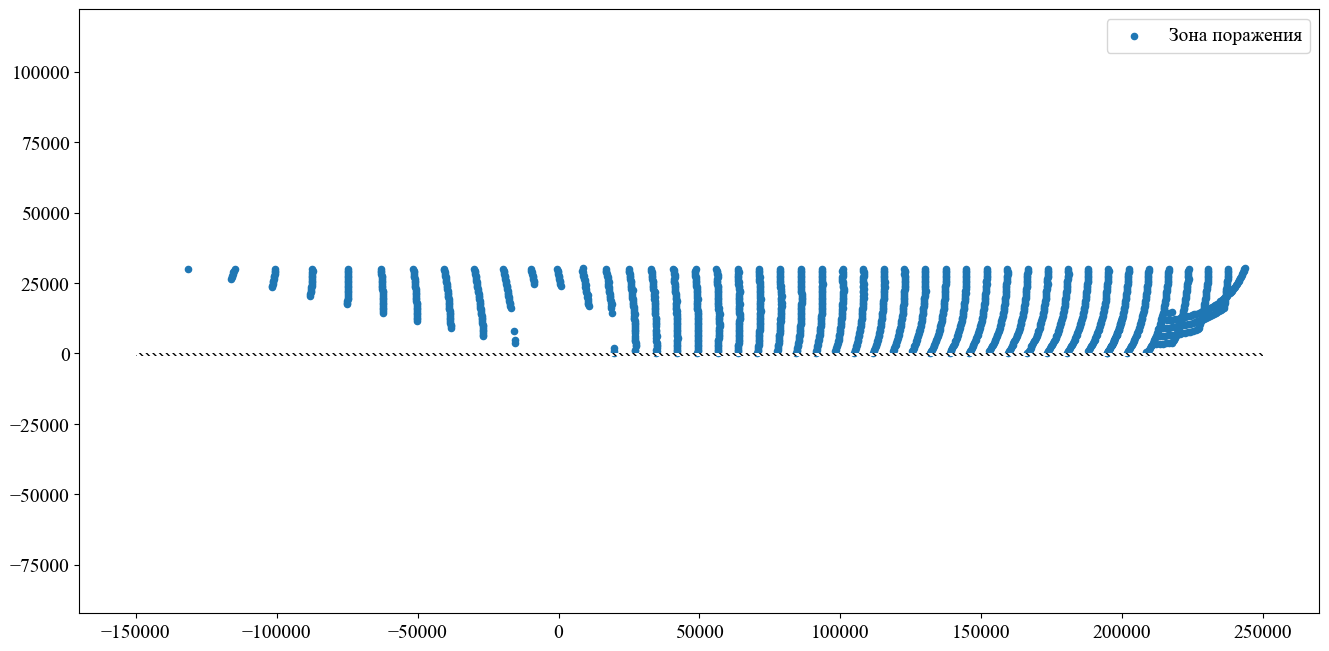

In [163]:
plt.figure(figsize=(16, 8), dpi=100)
plt.scatter(zone_xs, zone_ys, s=20, label='Зона поражения')
plt.fill_between([-150e3,250e3], [0,0], [-1000,-1000], facecolor='white', hatch='\\\\\\\\\\', linewidth=0.5)
# plt.scatter(zone_pusk_xs, zone_pusk_ys, s=25, label='Зона пуска')
plt.legend(fontsize=14)
plt.axis('equal')
plt.ylim(-100, 30000)
plt.tick_params(labelsize=14)
plt.savefig('pictures/Зона поражения.png', dpi=700, bbox_inches='tight')
plt.show()

### 3.2. Баллистический расчет самой дальней точки поражения

In [152]:
trg_pos = (max(zone_pusk_xs), max(zone_pusk_ys))
# trg_pos = (0, 8e3)

In [153]:
%time res_hit = foo_gym_hit(opts, trg_pos, trg_vel, aero=True, record=True)

meet: True; meeting point: [253854.44257245  30000.        ]
info = target destroyed
Wall time: 7min 48s


In [158]:
max(res_hit['missile']['v']), np.average(res_hit['missile']['v'])

(2447.8957221288024, 1699.8246430854)

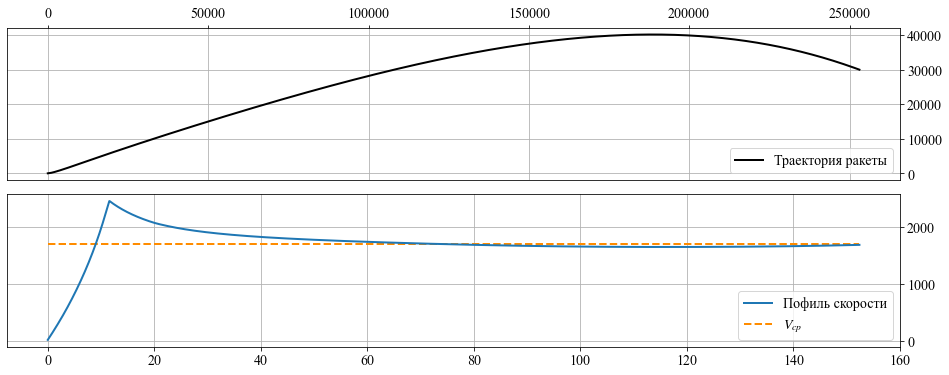

In [159]:
plt.figure(figsize=(16,12))

ax01 = subplot2grid((8, 4), (0, 0), colspan=4, rowspan=2)
ax00 = subplot2grid((8, 4), (2, 0), colspan=4, rowspan=2)

ax00.plot(res_hit['t'], res_hit['missile']['v'], lw=2, ls='-', label='Пофиль скорости')
ax00.hlines(np.average(res_hit['missile']['v']), 0, res_hit['t'][-1], ls='--', color='darkorange', lw=2, label='$V_{ср}$')
ax00.legend(loc='best', fontsize=14)
ax00.tick_params(left=False, labelleft=False, right=True, labelright=True, labelsize=14)
ax00.grid(True)

ax01.plot(res_hit['missile']['x'], res_hit['missile']['y'], lw=2, ls='-', color='k', label='Траектория ракеты')
ax01.legend(loc='lower right', fontsize=14)
ax01.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labeltop=True, top=True, labelsize=14)
ax01.grid(True)

plt.savefig('pictures/Профиль точный.png', dpi=300, bbox_inches='tight')

In [160]:
Cya = []
Cy_alpha_korp = []
Cy_alpha_oper = []
Cx  = []
Cx_0 = []
Cx_0_korp = []
Cx_0_oper = []
Cx_ind = []
Cx_ind_korp = []
Cx_ind_oper = []
t   = []
alpha = []
Mach = []
m_z_cy = []
m_z_wz = []
m_z_wz_korp = []
m_z_wz_oper = []
x_fa = []
x_fa_oper = []
x_fa_korp = []
x_fd_oper = []
ballans_relation = []
M_z_alpha = []
for i in range(1, len(res_hit['aero'])):
    
    Cya.append(res_hit['aero'][i]['Cy_alpha'])
    Cy_alpha_korp.append(res_hit['aero'][i]['Cy_alpha_korp'])
    Cy_alpha_oper.append(res_hit['aero'][i]['Cy_alpha_oper'])
    
    Cx.append(res_hit['aero'][i]['Cx'])
    Cx_0.append(res_hit['aero'][i]['Cx_0'])
    Cx_0_korp.append(res_hit['aero'][i]['Cx_0_korp'])
    Cx_0_oper.append(res_hit['aero'][i]['Cx_0_oper'])
    Cx_ind.append(res_hit['aero'][i]['Cx_ind'])
    Cx_ind_korp.append(res_hit['aero'][i]['Cx_ind_korp'])
    Cx_ind_oper.append(res_hit['aero'][i]['Cx_ind_oper'])
    
    m_z_cy.append(res_hit['aero'][i]['m_z_cy'])
    m_z_wz.append(res_hit['aero'][i]['m_z_wz'])
    m_z_wz_korp.append(res_hit['aero'][i]['m_z_wz_korp'])
    m_z_wz_oper.append(res_hit['aero'][i]['m_z_wz_oper'])
    
    x_fa.append(res_hit['aero'][i]['x_fa'])
    x_fa_oper.append(res_hit['aero'][i]['x_fa_oper'])
    x_fa_korp.append(res_hit['aero'][i]['x_fa_korp'])
    x_fd_oper.append(res_hit['aero'][i]['x_fd_oper'])
    
    ballans_relation.append(res_hit['aero'][i]['ballans_relation'])
    
    t.append(res_hit['aero'][i]['t'])
    alpha.append(res_hit['aero'][i]['alpha'])
    Mach.append(res_hit['aero'][i]['Mach'])

In [161]:
@interact(i=ipywidgets.IntSlider(description='tau', max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_aero_gym_hit(i):
    
    plt.figure(figsize=(16,12))

    ax00 = subplot2grid((8, 4), (0, 2), colspan=2, rowspan=2)
    ax01 = subplot2grid((8, 4), (0, 0), colspan=2, rowspan=2)
    ax02 = subplot2grid((8, 4), (2, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((8, 4), (4, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((8, 4), (2, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((8, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax06 = subplot2grid((8, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax07 = subplot2grid((8, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    
    ax00.plot(t[:i], Mach[:i], lw=3, ls=':', color='k', label='Mach')
    ax00.legend(loc='best', fontsize=14)
    ax00.tick_params(left=False, labelleft=False, right=True, labelright=True,  pad = 0, labelsize=12)
    ax00.grid(True)
    
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['y'][:i], lw=3, ls=':', color='k', label='траектория ракеты')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['y'][:i], lw=3, ls=':', color='red', label='траектория цели')
    ax01.tick_params(labelsize=12, pad = 0)
    ax01.legend(loc='best', fontsize=14)
    ax01.grid(True)
    
    ax02.plot(t[:i], Cya[:i], label='$C_{Y.ЛА}^{a}$', c='k')
    ax02.plot(t[:i], Cy_alpha_korp[:i], label='$C_{Y.корп}^{a}$', c='blue')
    ax02.plot(t[:i], Cy_alpha_oper[:i], label='$C_{Y.опер}^{a}$', c='red')
    ax02.tick_params(labeltop=False, top=False, labelbottom=False, bottom=False, labelsize=12)
    ax02.legend(fontsize=14)
    ax02.grid(True)
    
    ax03.plot(t[:i], Cx[:i], label='$C_{X.ЛА}$', c='k')
    ax03.plot(t[:i], Cx_0[:i], label=r'$C_{X0.ЛА}$', c='k', ls='-.')
    ax03.plot(t[:i], Cx_ind[:i], label=r'$C_{Xind.ЛА}$', c='k', ls='--')
    ax03.plot(t[:i], Cx_0_korp[:i], label=r'$C_{X0.корп}$', c='blue', ls='-.')
    ax03.plot(t[:i], Cx_ind_korp[:i], label=r'$C_{Xind.корп}$', c='blue', ls='--')
    ax03.plot(t[:i], Cx_0_oper[:i], label=r'$C_{X0.опер}$', c='red', ls='-.')
    ax03.plot(t[:i], Cx_ind_oper[:i], label=r'$C_{Xind.опер}$', c='red', ls='--')
    ax03.legend(loc='best', ncol=3, fontsize=14)
    ax03.tick_params(left=True, labelleft=True, labelbottom=False, bottom=False, labelsize=12)
    ax03.grid(True)
    
    ax04.plot(t[:i], m_z_wz[:i], label='$m_z^{wz}$', color='black', ls='-')
    ax04.plot(t[:i], m_z_wz_korp[:i], label='$m_{z.корп}^{wz}$', color='blue', ls='--')
    ax04.plot(t[:i], m_z_wz_oper[:i], label='$m_{z.опер}^{wz}$', color='red', ls='-.')
    ax04.tick_params(labeltop=False, top=False, pad = 10, left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=12)
    ax04.legend(fontsize=14)
    ax04.grid(True)
       
    ax05.plot(t[:i], x_fa[:i], color='darkorange', label='$x_{fa}$')
    ax05.plot(t[:i], x_fa_korp[:i], color='blue', label='$x_{fa.korp}$')
    ax05.plot(t[:i], x_fa_oper[:i], color='red', label='$x_{fa.oper}$')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=12)
    ax05.legend(fontsize=14)
    ax05.grid(True)
    
    ax06.plot(t[:i], m_z_cy[:i], label='$m_z^{Cy}$', color='darkorange')
    ax06.tick_params(labelbottom=True, bottom=True, labelsize=12)
    ax06.legend(fontsize=14)
    ax06.grid(True)
    
    ax07.plot(t[:i], ballans_relation[:i], label='$δ / α$', color='darkorange')
#     ax07.plot(t[:i], M_z_delt[:i], label='$M_{z}^δ$', color='red')
#     ax07.plot(t[:i], M_z_alpha[:i], label='$M_{z}^α$', color='green')
    ax07.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=True, bottom=True, labelsize=12)
    ax07.legend(fontsize=14)
    ax07
    ax07.grid(True)
    
    plt.savefig('pictures/Аэродинамика ЛА.png', dpi=900, bbox_inches='tight')
    
    plt.show()

interactive(children=(IntSlider(value=3048, description='tau', max=3048), Output()), _dom_classes=('widget-int…

In [162]:
@interact(i=ipywidgets.IntSlider(description='tau', max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_gym_hit(i):
    
    plt.figure(figsize=(16,12))
    
    ax01 = subplot2grid((8, 4), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((8, 4), (4, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((8, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((8, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((8, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['y'][:i], lw=3, ls=':', color='k', label='траектория ракеты')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['y'][:i], lw=3, ls=':', color='red', label='траектория цели')
    ax01.tick_params(labelsize=12, pad = 0)
    ax01.legend(loc='best', fontsize=14)
    ax01.grid(True)
    
    ax02.plot(res_hit['t'][:i], res_hit['missile']['v'][:i], label='$V_р$', c='k')
    ax02.plot(res_hit['t'][:i], res_hit['target']['v'][:i], label='$V_ц$', c='red')
    ax02.tick_params(left=True, labelleft=True,labelbottom=False, bottom=False, right=False, labelright=False, labelsize=12)
    ax02.legend(fontsize=14)
    ax02.grid(True)
    
    ax03.plot(res_hit['t'][:i], res_hit['missile']['ny'][:i], label=r'$n_y$ ракеты', c='k')
    ax03.plot(res_hit['t'][:i], res_hit['missile']['nx'][:i], label=r'$n_x$ ракеты', c='k', ls='--')
    ax03.plot(res_hit['t'][:i], res_hit['target']['ny'][:i], label=r'$n_y$ цели', c='red')
    ax03.plot(res_hit['t'][:i], res_hit['target']['nx'][:i], label=r'$n_x$ цели', c='red', ls='--')
    ax03.legend(loc='best', ncol=2, fontsize=14)
    ax03.tick_params(left=True, labelleft=True, right=False, labelright=False, labelsize=12)
    ax03.grid(True)
    
    ax04.plot(res_hit['t'][:i], res_hit['missile']['alpha'][:i], label=r'$\alpha$', color='k')
    ax04.plot(res_hit['t'][:i], res_hit['alpha_targeting'][:i], label=r'$\alpha_{пот}$', color='darkorange', ls='-')
    ax04.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, right=True, labelright=True, labelsize=12)
    ax04.legend(fontsize=14)
    ax04.grid(True)
       
    ax05.plot(res_hit['t'][:i], res_hit['missile']['Q'][:i], color='k', label='Q')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelsize=12)
    ax05.legend(fontsize=14)
    ax05.grid(True)
    
    plt.savefig('pictures/Баллистика.png', dpi=900, bbox_inches='tight')
    
    plt.show()

interactive(children=(IntSlider(value=3048, description='tau', max=3048), Output()), _dom_classes=('widget-int…